# Script 19: Plot de Satélite
Neste script vamos ver como baixar, reprojetar e plotar uma imagem do satélite GOES-16. Maiores detalhes no curso de "Processamento de Dados de Satélites", também no nosso Moodle.

File /content/Samples/OR_ABI-L2-CMIPF-M6C13_G16_s20212000000228_e20212000009547_c20212000010036.nc exists


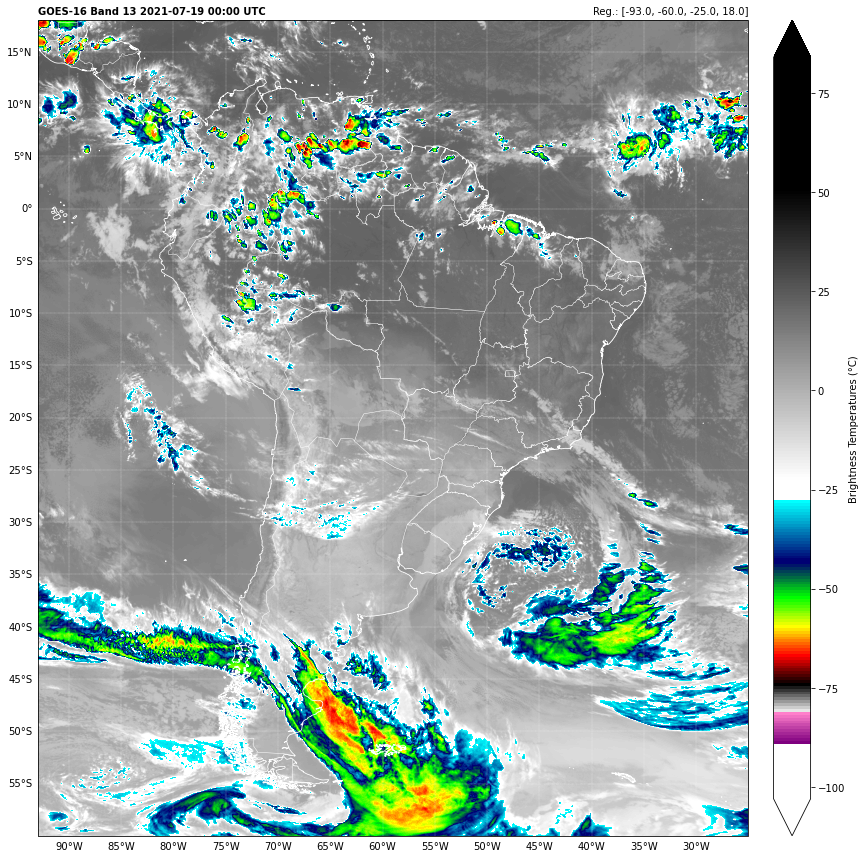

In [1]:
#-----------------------------------------------------------------------------------------------------------
# Curso INPE / CPTEC - Training: Python and GOES-R Imagery: Script 19 - Satellite Plot
# Instrutor: Diego Souza
# Adaptado: Dejanira F Braz
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset                         # Read / Write NetCDF4 files
from osgeo import gdal                              # Python bindings for GDAL
import matplotlib.pyplot as plt                     # Plotting library
import cartopy, cartopy.crs as ccrs                 # Plot maps
import cartopy.io.shapereader as shpreader          # Import shapefiles
import os                                           # Miscellaneous operating system interfaces
import numpy as np                                  # Scientific computing with Python
from matplotlib import cm                           # Colormap handling utilities
from datetime import timedelta, date, datetime      # Basic Dates and time types
from utilities import download_CMI                  # Our function for download
from utilities import reproject                     # Our function for reproject
from utilities import loadCPT                       # Import the CPT convert function
gdal.PushErrorHandler('CPLQuietErrorHandler')       # Ignore GDAL warnings
#-----------------------------------------------------------------------------------------------------------

# Select the extent [min. lon, min. lat, max. lon, max. lat]
extent = [-93.0, -60.00, -25.00, 18.00] 

# Input and output directories
input = "/content/Samples"; os.makedirs(input, exist_ok=True)
output = "/content/Output"; os.makedirs(output, exist_ok=True)

# Datetime to process (today in this example, to match the GFS date)
date = datetime.today().strftime('%Y%m%d')
yyyymmddhhmn = date + '0000'

#-----------------------------------------------------------------------------------------------------------

# Download the ABI file
file_ir = download_CMI(yyyymmddhhmn, 13, input)

#-----------------------------------------------------------------------------------------------------------
# Variable
var = 'CMI'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_ir}.nc:' + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds_cmi = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
ds_cmi = (ds_cmi * scale + offset) - 273.15

# Reproject the file
filename_ret = f'{output}/IR_{yyyymmddhhmn}.nc'
reproject(filename_ret, img, ds_cmi, extent, undef)

# Open the reprojected GOES-R image
file = Dataset(filename_ret)

# Get the pixel values
data = file.variables['Band1'][:]
#----------------------------------------------------------------------------------------------------------- 

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(15,15))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]
ax.set_extent([extent[0], extent[2], extent[1], extent[3]], ccrs.PlateCarree())

# Converts a CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
cmap = cm.colors.LinearSegmentedColormap('cpt', cpt) 
    
# Plot the image
img1 = ax.imshow(data, origin='upper', vmin=-103.0, vmax=84, extent=img_extent, cmap=cmap, alpha=1.0)

# Define the color scale based on the channel
#colormap = "gray_r" # White to black for IR channels
    
# Plot the image
#img1 = ax.imshow(data, origin='upper', vmin=-80, vmax=60, extent=img_extent, cmap=colormap, alpha=1.0)

# Add a shapefile
# https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
shapefile = list(shpreader.Reader('Shapefile/BR_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white',facecolor='none', linewidth=0.3)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='white', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add a colorbar
plt.colorbar(img1, label='Brightness Temperatures (°C)', extend='both', orientation='vertical', pad=0.03, fraction=0.05)

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band 13 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/image_19.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('image_19.png')
# Show the image
plt.show()
